In [11]:
import numpy as np
from scipy.linalg import eigh, qr, null_space
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.sparse import kron, identity, csr_matrix, lil_matrix, dok_matrix
from scipy.sparse.linalg import eigsh, eigs
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn, qeye, tensor
from tqdm import tqdm
from itertools import product
from functools import reduce
import torch
import torch.optim as optim
from torch.autograd import Variable
import sympy as sp
import networkx as nx

In [17]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])


def transverse_field_ising_triangular(m, n, J, h, periodic):
    """
    Constructs the Hamiltonian for the transverse field Ising model on an icosahedral molecular structure.
    
    Parameters:
        m (int): Number of rows in the triangular lattice.
        n (int): Number of columns in the triangular lattice.
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    # Get triangular bonds + sites number
    tri= nx.triangular_lattice_graph(m, n, periodic, with_positions=True, create_using=None)
    # Assign indices to nodes
    node_indices = {node: index for index, node in enumerate(tri.nodes())}
    # Print edges using indices
    bonds = [(node_indices[edge[0]], node_indices[edge[1]]) for edge in tri.edges()]
    print("bonds", bonds)

    N = tri.number_of_nodes()

    # Relabel nodes in the graph using their indices
    tri_relabelled = nx.relabel_nodes(tri, node_indices)

    # Draw the graph with indices as labels
    plt.figure(figsize=(8, 6))
    nx.draw(tri_relabelled, with_labels=True, node_size=500, font_size=10)
    plt.show()

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)
        
    # Interaction term: J * sigma_i^x * sigma_j^x for icosahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

#######################################################################################################################

'''
def partial_trace_qubit(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits."""
    keep_dims = np.prod([dims[i] for i in keep])
    trace_dims = np.prod([dims[i] for i in range(len(dims)) if i not in keep])
    rho = rho.reshape([keep_dims, trace_dims, keep_dims, trace_dims])
    return np.trace(rho, axis1=1, axis2=3).reshape([keep_dims, keep_dims])

def partial_trace_qubit_torch(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits using PyTorch."""
    keep_dims = torch.prod(torch.tensor([dims[i] for i in keep]))
    trace_dims = torch.prod(torch.tensor([dims[i] for i in range(len(dims)) if i not in keep]))
    rho = rho.view(keep_dims, trace_dims, keep_dims, trace_dims)
    # Compute the partial trace
    traced_rho = torch.zeros((keep_dims, keep_dims), dtype=rho.dtype)
    for i in range(trace_dims):
        traced_rho += rho[:, i, :, i]
    #return traced_rho.view(keep_dims, keep_dims)
    return traced_rho'''

def isket_numpy(arr):
    """
    Check if a NumPy array is a ket (column vector).

    Parameters:
    - arr: np.ndarray, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_numpy(Q, sel, dims): # numpy function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using NumPy.

    Parameters:
    - Q: numpy object, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - numpy object, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = np.asarray(dims[0], dtype=np.int32).ravel()
    nd = len(rd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = np.array([sel])
    else:
        sel = np.asarray(sel)
    sel = list(np.sort(sel))
    
    # Dimensions of the subsystems to keep
    dkeep = (rd[sel]).tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(np.arange(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = (rd[qtrace]).tolist()
    
    # Reshape the density matrix or state vector
    rd = list(rd)
    if isket_numpy(Q):
        # Reshape and transpose for state vector
        vmat = (Q
                .reshape(rd)
                .transpose(sel + qtrace)
                .reshape([np.prod(dkeep), np.prod(dtrace)]))
        # Compute the reduced density matrix
        rhomat = vmat.dot(vmat.conj().T)
    else:
        # Reshape and transpose for density matrix
        rhomat = np.trace(Q
                          .reshape(rd + rd)
                          .transpose(qtrace + [nd + q for q in qtrace] +
                                     sel + [nd + q for q in sel])
                          .reshape([np.prod(dtrace),
                                    np.prod(dtrace),
                                    np.prod(dkeep),
                                    np.prod(dkeep)]))
    return rhomat

def isket_torch(arr):
    """
    Check if a PyTorch tensor is a ket (column vector).

    Parameters:
    - arr: torch.Tensor, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_torch(Q, sel, dims): # torch function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using PyTorch.

    Parameters:
    - Q: torch.Tensor, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - torch.Tensor, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = torch.tensor(dims[0], dtype=torch.int32).flatten()
    nd = len(rd)
    #print("rd", rd)
    #print("nd", nd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = torch.tensor([sel])
    else:
        sel = torch.tensor(sel)
    sel = torch.sort(sel).values.tolist()
    
    # Dimensions of the subsystems to keep
    dkeep = rd[sel].tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(range(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = rd[qtrace].tolist()
    
    # Reshape the density matrix or state vector
    rd = rd.tolist()
    if isket_torch(Q):
        # Reshape and transpose for state vector
        reshaped_Q = Q.reshape(rd)
        #print(reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(sel + qtrace)
        #print(transposed_Q.shape)
        vmat = transposed_Q.reshape([torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dtrace))])
        #print(vmat.shape)
        # Compute the reduced density matrix
        rhomat = vmat @ vmat.conj().T
        #print(rhomat.shape)
    else:
        # Reshape and transpose for density matrix
        reshaped_Q = Q.reshape(rd + rd)
        #print("reshaped_Q", reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(qtrace + [nd + q for q in qtrace] + sel + [nd + q for q in sel])
        #print("transposed_Q", transposed_Q.shape)
        reshaped_transposed_Q = transposed_Q.reshape([torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))])
        #print("reshaped_transposed_Q", reshaped_transposed_Q.shape)
        #rhomat = torch.trace(reshaped_transposed_Q)
        rhomat = torch.einsum('iikl->kl', reshaped_transposed_Q)
        # Trace out the first two dimensions
        #rhomat = torch.zeros((torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))), dtype=Q.dtype)
        #for i in range(reshaped_transposed_Q.shape[0]):
        #    for j in range(reshaped_transposed_Q.shape[1]):
        #        rhomat += reshaped_transposed_Q[i, j, :, :]
        #print("rhomat", rhomat.shape)
    return rhomat

def entanglement_entropy(psi, subsystem_size, total_size):

    '''Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.'''
    
    psi_matrix =  np.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_numpy(psi_matrix, list(range(subsystem_size)), [[2]*total_size, [2]*total_size])  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch(psi, subsystem_size, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state using PyTorch.

    Parameters:
    - psi: torch.Tensor (complex), the wavefunction (state vector) of the full system.
    - subsystem_size: int, the number of qubits in subsystem A.
    - total_size: int, the total number of qubits in the system.

    Returns:
    - torch.Tensor (scalar), the von Neumann entanglement entropy S_A.
    """

    if not isinstance(psi, torch.Tensor):
        psi = torch.tensor(psi, dtype=torch.complex64)
    
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Compute the density matrix |psi><psi|
    psi_matrix = torch.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_torch(psi_matrix, list(range(subsystem_size)), [[2] * total_size, [2] * total_size])  # Partial trace over B

    #rho_A = rho_A.to(dtype=torch.float64)
    
    # Compute eigenvalues of rho_A
    eigvals = torch.linalg.eigvalsh(rho_A)

    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigvals = eigvals[eigvals > 0]

    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -torch.sum(eigvals * torch.log2(eigvals))

    return entropy


def entanglement_entropy_qutip(psi, subsystem_size, total_size):
    
    # Convert the wavefunction to a QuTiP Qobj
    density_matrix = np.outer(psi, psi.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*total_size, [2]*total_size])

    rho_A = ptrace(density_matrix_qobj, list(range(subsystem_size)))
    # Compute the von Neumann entropy S_A
    entropy = entropy_vn(rho_A, base=2)
    
    return entropy

def entanglement_entropy_np_ptrace(rdm):
    # rdm already computed and converted to numpy
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rdm)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch_ptrace(rdm):

    eigvals = torch.linalg.eigvalsh(rdm)
    eigvals = eigvals[eigvals > 0]
    entropy = -torch.sum(eigvals * torch.log2(eigvals))
    return entropy


def entanglement_entropy_qutip_torch(psi, N):
    """
    Compute the von Neumann entanglement entropy using qutip.

    Parameters:
    - psi: torch.Tensor (complex), state vector of a quantum system.
    - N: int, total number of qubits.

    Returns:
    - torch.Tensor (scalar), von Neumann entropy.
    """
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Convert PyTorch tensor to NumPy for QuTiP
    psi_np = psi.detach().numpy()

    rho_np = np.outer(psi_np, psi_np.conj())
    rho_qobj = Qobj(rho_np, dims=[[2] * N, [2] * N])

    rho_A = ptrace(rho_qobj, list(range(N // 2)))

    # Compute von Neumann entropy
    entropy = entropy_vn(rho_A, base=2)  # Compute in log base 2

    # Convert back to PyTorch tensor to allow gradient flow
    return torch.tensor(entropy, dtype=torch.float32, requires_grad=True)

#######################################################################################################################

# Define the linear combination function - numpy
def linear_combination_np(coeffs, psis):
    # Ensure psis are numpy tensors
    psi_np = [np.array(psi) for psi in psis]
    # Compute the linear combination in PyTorch
    psi = sum(c * psi for c, psi in zip(coeffs, psis))
    
    return psi

# Define the linear combination function - torch
def linear_combination(coeffs, psis):
    # Ensure psis are PyTorch tensors
    psis_torch = [torch.tensor(psi, dtype=torch.complex64) if not isinstance(psi, torch.Tensor) else psi for psi in psis]
    
    # Compute the linear combination in PyTorch
    psi_torch = sum(c * psi for c, psi in zip(coeffs, psis_torch))
    
    return psi_torch

# Define the linear combination function - torch but after computing the ptrace of outer products of scars
def linear_combination_outer(coeffs, outs):
    # Ensure outs are PyTorch tensors
    outs_torch = [torch.tensor(out, dtype=torch.complex64) if not isinstance(out, torch.Tensor) else out for out in outs]
    torch_coeffs = torch.tensor(coeffs, dtype=torch.complex64)

    # Compute the PyTorch tensor of out_coeffs which is the product of all possible combinations of c_i^* times c_j
    out_coeffs = torch.zeros((len(torch_coeffs), len(torch_coeffs)), dtype=torch.complex64)
    for i in range(len(torch_coeffs)):
        for j in range(len(torch_coeffs)):
            out_coeffs[i, j] = torch.conj(torch_coeffs[i]) * torch_coeffs[j]
    
    # Compute the linear combination in PyTorch
    lin_torch = sum(out_coeffs[i, j] * outs_torch[i] for i in range(len(coeffs)) for j in range(len(coeffs)))
    
    return lin_torch

######################################################

# Function to apply permutation to a given spin configuration
def apply_permutation(state_bits, N, perm):
    new_bits = [0] * N
    for i in range(N):
        new_bits[perm[i]] = state_bits[i]  # Map value at index i to perm[i]
    return new_bits

bonds [(0, 1), (0, 3), (0, 9), (0, 2), (0, 5), (0, 11), (1, 2), (1, 4), (1, 3), (1, 9), (1, 10), (2, 5), (2, 4), (2, 10), (2, 11), (3, 4), (3, 6), (3, 7), (3, 5), (4, 5), (4, 7), (4, 8), (5, 8), (5, 6), (6, 7), (6, 9), (6, 8), (6, 11), (7, 8), (7, 10), (7, 9), (8, 11), (8, 10), (9, 10), (9, 11), (10, 11)]


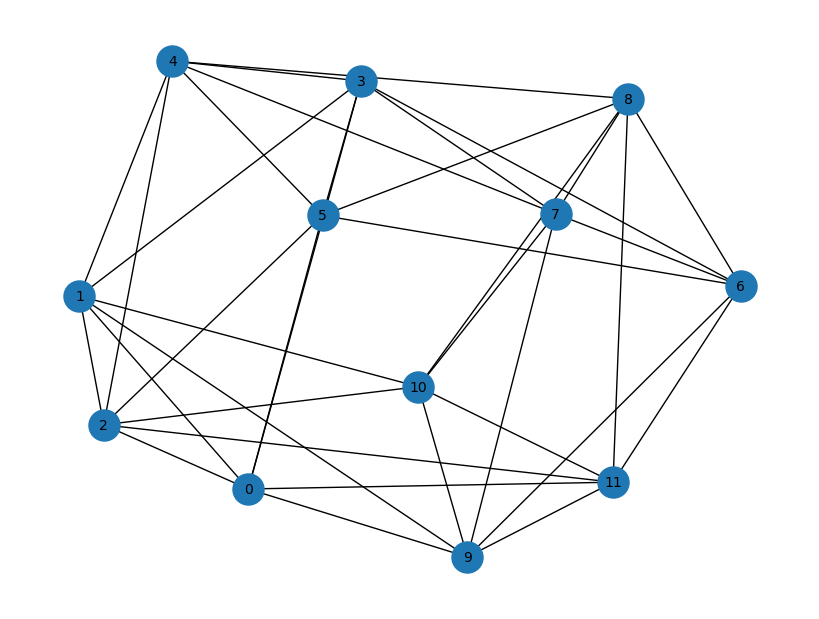

In [37]:
N = 12  # Number of spins
m = 4  # Number of rows in the triangular lattice
n = 6  # Number of columns in the triangular lattice
J = 1.0  # Interaction strength
h = 1.0  # Transverse field strength # this is the value in the paper. maybe try  other values too, including the critical value one (h=J=1)



# Assuming transverse_field_ising is defined and returns a sparse Hermitian matrix
H = transverse_field_ising_triangular(m, n, J, h, periodic=True)

#print(f"Hamiltonian shape: {H.shape}")
#print(f"Non-zero elements in H: {H.nnz}")

# Define the C5 permutation mapping for your case - around axis through vert 9 and 10 ##### modify for  triangular lattice
perm = {
    0: 2,
    2: 7,
    7: 11,
    11: 5,
    5: 0,
    1: 3,
    3: 4,
    4: 8,
    8: 6,
    6: 1,
    9: 9,   # Fixed
    10: 10  # Fixed
}

In [38]:
# All eigenvalues of H
# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

print(f"Eigenvalues of H: {np.sort(eigenvalues)}")
print(len(eigenvalues))

Eigenvalues of H: [-18.29785746 -17.99699015 -17.99699015 ...  25.34128776  37.00141025
  37.00141052]
4096


In [43]:
# 3 spins rdm - qutip

min_eigenvalues = []
min_rdms = []
rdm_eigenvalues = []

#keep_qubits = [0, 1, 2]  # 3 spins - 1 traingular plaquette
keep_qubits = [0, 1, 2, 3]  # 4 spins - 2 adjacent traingular plaquettes


for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out qubits
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()
    # Check if the rank is not full and print it
    rank = np.linalg.matrix_rank(traced_out_density_matrix_dense)
    if rank < traced_out_density_matrix_dense.shape[0]:
        print(f"Traced-out density matrix rank: {rank}")
    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
      min_rdms.append(traced_out_density_matrix_dense) #store the scarred rdms - step needed for optimization
      rdm_eigenvalues.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms

100%|██████████| 4096/4096 [11:21<00:00,  6.01it/s]


In [40]:
# print rdm rank + rdm + rdm eigenvalues for non scarred points - p.e. last state in the for loop

print(eigenvalues_traced)

print(np.linalg.matrix_rank(traced_out_density_matrix_dense))

# Count entries of eigenvalues_traced that are greater than 1e-16
countf = np.sum(eigenvalues_traced > 1e-16)
print(countf)

# rank is full - 16 for 4 spins or 32 for 5 spins

[1.40385836e-06 1.40385836e-06 2.50116241e-06 2.50116241e-06
 4.56096952e-06 1.15804371e-05 4.96851692e-01 5.03124356e-01]
8
8


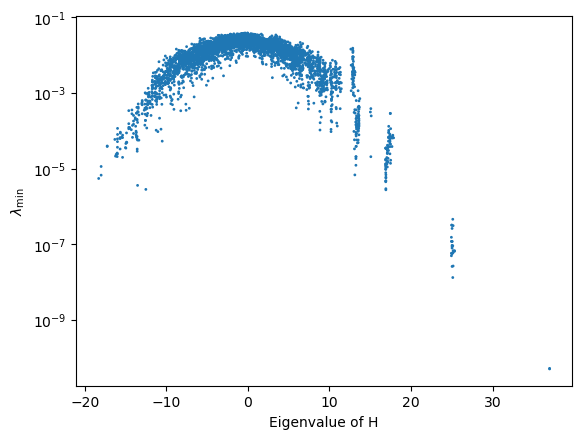

In [44]:
#Define the threshold - qutip
threshold = 1e-16
min_eigenvalues = np.array(min_eigenvalues)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

In [42]:
# Find indices of red points - qutip
red_indices = [i for i, y in enumerate(min_eigenvalues) if y < threshold]
print(f'Indices of red points: {red_indices}')

red_eigenvectors = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms[i])}')
    red_eigenvectors.append(eigenvectors[:, ind])

for i in range(len(red_indices)):
    for j in range(len(red_indices)):
        idx1, idx2 = red_indices[i], red_indices[j]
        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues[i] - eigenvalues of the scarred rdms - that are non-zero
counts = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts}')

Indices of red points: []
Counts of non-zero eigenvalues of the scarred rdms: []


In [9]:
# 4/5 spins rdm - numpy

min_eigenvalues_np = []
min_rdms_np =[]
rdm_eigenvalues_np = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

    # Trace out qubits
    traced_out_density_matrix = ptrace_numpy(density_matrix, keep_qubits, [[2]*N, [2]*N])

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues_np.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_np.append(traced_out_density_matrix) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues_np.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms

100%|██████████| 4096/4096 [13:30<00:00,  5.05it/s]


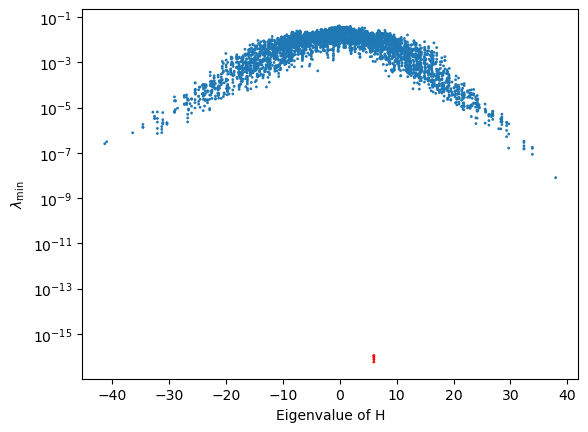

In [10]:
# numpy

# Define the threshold
threshold = 1e-16
min_eigenvalues_np = np.array(min_eigenvalues_np)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_np if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues_np), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

In [11]:
# Find indices of red points - numpy
red_indices_np = [i for i, y in enumerate(min_eigenvalues_np) if y < threshold]
print(f'Indices of red points: {red_indices_np}')

red_eigenvectors_np = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices_np):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_np[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_np[i])}')
    red_eigenvectors_np.append(eigenvectors[:, ind])

for i in range(len(red_indices_np)):
    for j in range(len(red_indices_np)):
        idx1, idx2 = red_indices_np[i], red_indices_np[j]
        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues_np[i] - eigenvalues of the scarred rdms - that are non-zero
counts_np = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues_np]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts_np}')

Indices of red points: [2825, 2826, 2827, 2828, 2829]
0 2825
Eigenvalue: 5.999999999999997, rdm Minimum Eigenvalue: -1.1176994903292644e-16
Eigenvector 2825: rdm rank: 11
1 2826
Eigenvalue: 5.999999999999998, rdm Minimum Eigenvalue: -9.141503510728562e-17
Eigenvector 2826: rdm rank: 11
2 2827
Eigenvalue: 6.0, rdm Minimum Eigenvalue: -7.488496988605666e-17
Eigenvector 2827: rdm rank: 11
3 2828
Eigenvalue: 6.000000000000001, rdm Minimum Eigenvalue: -1.080377765207734e-16
Eigenvector 2828: rdm rank: 11
4 2829
Eigenvalue: 6.000000000000001, rdm Minimum Eigenvalue: -5.864231231741467e-17
Eigenvector 2829: rdm rank: 11
Dot product between eigenvectors 2825 and 2825: 0.9999999999999996
Dot product between eigenvectors 2825 and 2826: -1.0842021724855044e-16
Dot product between eigenvectors 2825 and 2827: 0.0
Dot product between eigenvectors 2825 and 2828: -3.469446951953614e-17
Dot product between eigenvectors 2825 and 2829: -4.119968255444917e-17
Dot product between eigenvectors 2826 and 2825

In [12]:
# 4/5 spins rdm - torch

min_eigenvalues_to = []
min_rdms_to = []
rdm_eigenvalues_to = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    min_eigenvector_torch = torch.tensor(min_eigenvector, dtype=torch.float64)
    density_matrix = torch.outer(min_eigenvector_torch, min_eigenvector_torch.conj())

    # Trace out qubits
    traced_out_density_matrix = ptrace_torch(density_matrix, keep_qubits, [[2] * N, [2] * N])
    traced_out_density_matrix = torch.tensor(traced_out_density_matrix, dtype=torch.float64) # necessary step to ensure that the scarred states have lambda_min of the correct order - <1e-16 

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = torch.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = torch.min(eigenvalues_traced).item()
    min_eigenvalues_to.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_to.append(traced_out_density_matrix.detach().cpu().numpy())  # store the scarred rdms - step needed for optimization
        rdm_eigenvalues_to.append(eigenvalues_traced.detach().cpu().numpy()) # store the eigenvalues of the scarred rdms

  0%|          | 0/4096 [00:00<?, ?it/s]C:\Users\camipolv\AppData\Local\Temp\ipykernel_9648\463037747.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  traced_out_density_matrix = torch.tensor(traced_out_density_matrix, dtype=torch.float64) # necessary step to ensure that the scarred states have lambda_min of the correct order - <1e-16
100%|██████████| 4096/4096 [10:39<00:00,  6.40it/s]


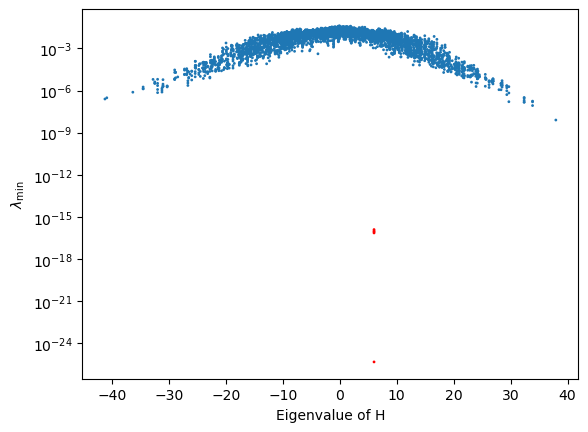

In [13]:
#torch

# Define the threshold
threshold = 1e-16
min_eigenvalues_to = np.array(min_eigenvalues_to)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_to if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_to]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues_to), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

In [14]:
# Find indices of red points - torch
red_indices_to = [i for i, y in enumerate(min_eigenvalues_to) if y < threshold]
print(f'Indices of red points: {red_indices_to}')

red_eigenvectors_to = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices_to):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_to[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_to[i])}')
    red_eigenvectors_to.append(eigenvectors[:, ind])

for i in range(len(red_indices_to)):
    for j in range(len(red_indices_to)):
        idx1, idx2 = red_indices_to[i], red_indices_to[j]
        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues_to[i] - eigenvalues of the scarred rdms - that are non-zero
counts_to = [np.sum(eigenvalues > 1e-15) for eigenvalues in rdm_eigenvalues_to]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts_to}')

Indices of red points: [2825, 2826, 2827, 2828, 2829]
0 2825
Eigenvalue: 5.999999999999997, rdm Minimum Eigenvalue: -1.027672604600349e-16
Eigenvector 2825: rdm rank: 11
1 2826
Eigenvalue: 5.999999999999998, rdm Minimum Eigenvalue: 4.8588762535809405e-26
Eigenvector 2826: rdm rank: 11
2 2827
Eigenvalue: 6.0, rdm Minimum Eigenvalue: -7.375692715770888e-17
Eigenvector 2827: rdm rank: 11
3 2828
Eigenvalue: 6.000000000000001, rdm Minimum Eigenvalue: -1.2772115391587055e-16
Eigenvector 2828: rdm rank: 11
4 2829
Eigenvalue: 6.000000000000001, rdm Minimum Eigenvalue: -8.808329763979084e-17
Eigenvector 2829: rdm rank: 11
Dot product between eigenvectors 2825 and 2825: 0.9999999999999996
Dot product between eigenvectors 2825 and 2826: -1.0842021724855044e-16
Dot product between eigenvectors 2825 and 2827: 0.0
Dot product between eigenvectors 2825 and 2828: -3.469446951953614e-17
Dot product between eigenvectors 2825 and 2829: -4.119968255444917e-17
Dot product between eigenvectors 2826 and 2825

In [32]:
# Generate random complex coefficients
random_coeffs = np.random.rand(len(red_indices)) + 1j* np.random.rand(len(red_indices))

# Normalize the coefficients
random_coeffs /= np.linalg.norm(random_coeffs)
print(random_coeffs)

print("coeffs norm",sum(np.abs(random_coeffs)**2))

# Define random scar state from 5 scarred states using random coefficients
rnd_scar = np.sum(eigenvectors[:, red_indices] * random_coeffs, axis=1)

print(len(rnd_scar))

# Save eigenvalues corresponding to red indices into a numpy array
red_eigenvalues = np.array([eigenvalues[i] for i in red_indices])

[]
coeffs norm 0
4096


In [33]:
# Count the number of zero entries
num_zeros = np.count_nonzero((rnd_scar.real < 1e-16) & (rnd_scar.imag < 1e-16))
print(f'Number of zero entries: {num_zeros}')

Number of zero entries: 4096


In [34]:
# RANDOM SCAR - RANDOM LINEAR COMBINATION OF SCARRED STATES

rnd_scar = linear_combination_np(random_coeffs, red_eigenvectors)
rnd_scar_entropy = entanglement_entropy(rnd_scar, N // 2, N)
rnd_scar_entropy_qutip = entanglement_entropy_qutip(rnd_scar, N // 2, N)
rnd_scar_entropy_torch = entanglement_entropy_torch(rnd_scar, N // 2, N)
print("Random scar coeffs", random_coeffs)
print(f"Entanglement entropy of random scar state: {rnd_scar_entropy}")
print(f"Entanglement entropy of random scar state (Qutip): {rnd_scar_entropy_qutip}")
print(f"Entanglement entropy of random scar state (PyTorch): {rnd_scar_entropy_torch}")

AttributeError: 'int' object has no attribute 'conj'

In [35]:
# Compute bipartite entanglement entropy for all eigenstates in the full Hilbert space
naive_entropies = [entanglement_entropy(eigenvectors[:, i], N // 2, N) for i in tqdm(range(eigenvectors.shape[1]))]
qutip_entropies = [entanglement_entropy_qutip(eigenvectors[:, i], N // 2, N) for i in tqdm(range(eigenvectors.shape[1]))]
torch_entropies = [entanglement_entropy_torch(eigenvectors[:, i], N // 2, N) for i in tqdm(range(eigenvectors.shape[1]))]

100%|██████████| 4096/4096 [02:31<00:00, 26.99it/s]


Entropies of red points:


c:\Users\camipolv\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\camipolv\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NameError: name 'rnd_scar_entropy' is not defined

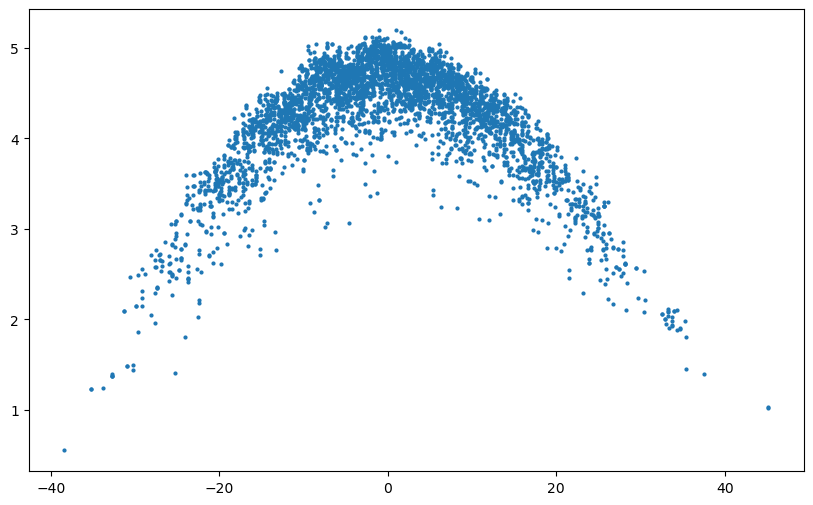

In [36]:
# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {naive_entropies[i]}')

#print(f'Random scar entropy: {rnd_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], naive_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), rnd_scar_entropy, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
plt.legend()
plt.show()

Entropies of red points:
Index: 2825, Entropy: 4.115514364937284
Index: 2826, Entropy: 3.361484936652742
Index: 2827, Entropy: 4.632998329262645
Index: 2828, Entropy: 4.118581173002289
Index: 2829, Entropy: 4.218787520105947
Random scar entropy: 4.513629081986895


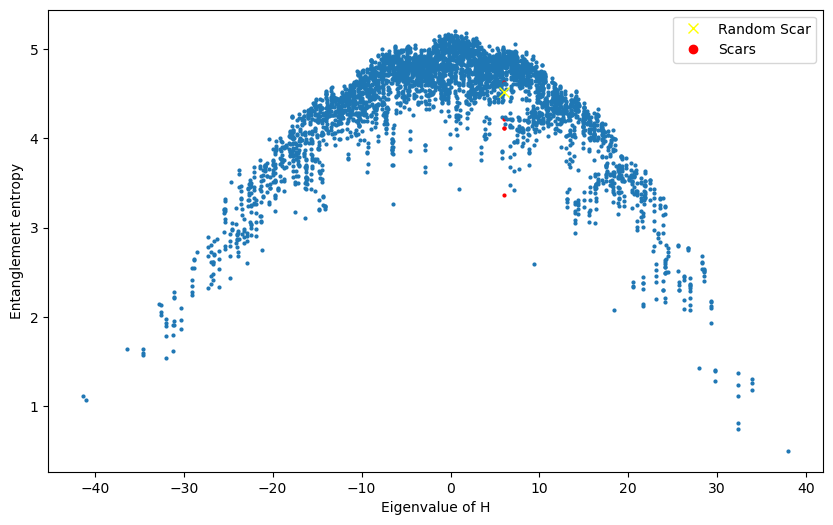

In [20]:
# Compute entanglement entropy for the rnd_scar wavefunction - qutip

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {qutip_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy_qutip}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], qutip_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_qutip, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
#plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()

Entropies of red points:
Index: 2825, Entropy: 4.115516185760498
Index: 2826, Entropy: 3.3614869117736816
Index: 2827, Entropy: 4.6330037117004395
Index: 2828, Entropy: 4.118582248687744
Index: 2829, Entropy: 4.218788146972656
Random scar entropy: 4.513631820678711


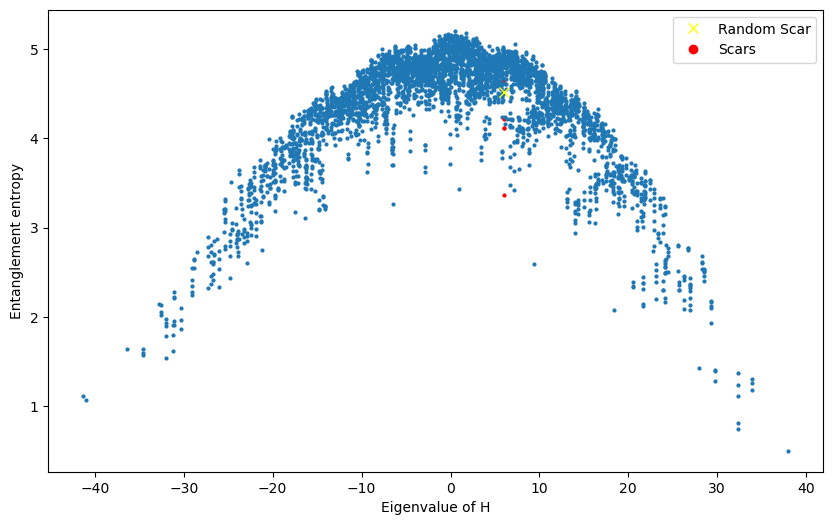

In [21]:
# Compute entanglement entropy for the rnd_scar wavefunction - torch

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {torch_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy_torch}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], torch_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_torch, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
#plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()

Entropies of red points:
Index: 2825, Entropy: 4.115514364937272
Index: 2826, Entropy: 3.3614849366527304
Index: 2827, Entropy: 4.632998329262636
Index: 2828, Entropy: 4.118581173002276
Index: 2829, Entropy: 4.218787520105936
Random scar entropy: 4.513629081986885


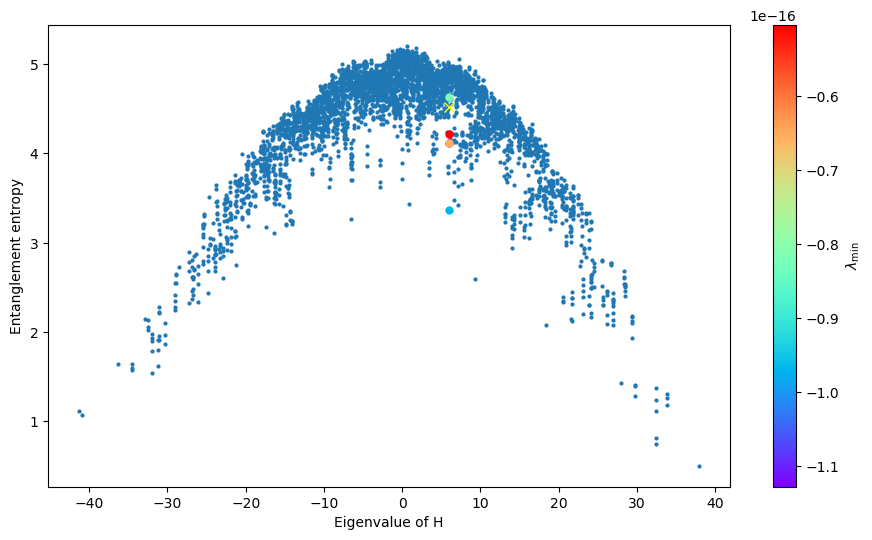

In [22]:
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices)))

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {naive_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(11, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], naive_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices):
    handle, = ax.plot(eigenvalues[idx], naive_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(f'λ_min: {float(min_eigenvalues[idx]):.2e}, Entropy: {naive_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
max_scar_handle, = ax.plot(np.mean(red_eigenvalues), rnd_scar_entropy, 'x', color='yellow', markersize=7)
handles.append(max_scar_handle)
labels.append('Max Scar, Entropy: {:.2f}'.format(rnd_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues[idx] for idx in red_indices]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label=r'$\lambda_{\mathrm{min}}$')

ax.set_xlabel('Eigenvalue of H')
ax.set_ylabel('Entanglement entropy')
#ax.set_title('Entanglement entropy as a function of energy eigenvalues')
plt.show()

In [24]:
# Let's look closer at the scar points with the lowest and highest entropy (Indeces: 1267, 1266)

# MIN ENTROPY

lowest_entropy_index = 1267
lowest_entropy_eigenvector = eigenvectors[:, lowest_entropy_index]
entanglement_entropy_value = entanglement_entropy(lowest_entropy_eigenvector, N // 2, N)
print(f'Lowest Entropy Index: {lowest_entropy_index}, Entropy: {entanglement_entropy_value}')   

# Convert the eigenvector to PyTorch tensors for real and imaginary parts
params_real = torch.tensor(lowest_entropy_eigenvector.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(lowest_entropy_eigenvector.imag, dtype=torch.float, requires_grad=True)

print("Initial coeffs, real:", params_real)
print("Initial coeffs, imag:", params_imag)

entanglement_entropy_value = entanglement_entropy_torch(lowest_entropy_eigenvector, N // 2, N)
print(f'Lowest Entropy Index: {lowest_entropy_index}, Entropy: {entanglement_entropy_value}')

# Define coefficients for the linear combination
min_coeffs = np.zeros(len(red_eigenvectors), dtype=np.complex128)  # Initialize all coefficients to 0
min_coeffs[red_indices.index(2825)] = 1  # Ensure the coefficient for index 2825 is explicitly set to 1


# MAX ENTROPY
highest_entropy_index = 1266
highest_entropy_eigenvector = eigenvectors[:, highest_entropy_index]
entanglement_entropy_value = entanglement_entropy(highest_entropy_eigenvector, N // 2, N)
print(f'Highest Entropy Index: {highest_entropy_index}, Entropy: {entanglement_entropy_value}') 

# Convert the eigenvector to PyTorch tensors for real and imaginary parts
params_real = torch.tensor(lowest_entropy_eigenvector.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(lowest_entropy_eigenvector.imag, dtype=torch.float, requires_grad=True)

print("Initial coeffs, real:", params_real)
print("Initial coeffs, imag:", params_imag)

entanglement_entropy_value = entanglement_entropy_torch(highest_entropy_eigenvector, N // 2, N)
print(f'Highest Entropy Index: {highest_entropy_index}, Entropy: {entanglement_entropy_value}')

# Define coefficients for the linear combination
max_coeffs = np.zeros(len(red_eigenvectors), dtype=np.complex128)  # Initialize all coefficients to 0
max_coeffs[red_indices.index(2825)] = 1  # Ensure the coefficient for index 2825 is explicitly set to 1


Lowest Entropy Index: 1267, Entropy: 4.694805667190192
Initial coeffs, real: tensor([ 0.0000e+00,  1.6887e-16,  1.5494e-16,  ..., -3.7297e-17,
         2.2551e-17, -1.3878e-17], requires_grad=True)
Initial coeffs, imag: tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True)
Lowest Entropy Index: 1267, Entropy: 4.69480562210083
Highest Entropy Index: 1266, Entropy: 4.767004054828529
Initial coeffs, real: tensor([ 0.0000e+00,  1.6887e-16,  1.5494e-16,  ..., -3.7297e-17,
         2.2551e-17, -1.3878e-17], requires_grad=True)
Initial coeffs, imag: tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True)
Highest Entropy Index: 1266, Entropy: 4.767005443572998


Initial Entropy: 4.115515232086182
Coeffs norm: 0.99999994
Entropy: 4.115515232086182
Coeffs: [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Coeffs norm: 0.99999994
Entropy: 4.0719709396362305
Coeffs: [ 0.9998001+0.j -0.009998 +0.j  0.009998 +0.j -0.009998 +0.j
 -0.009998 +0.j]
Coeffs norm: 0.99999994
Entropy: 4.0259809494018555
Coeffs: [ 0.99918836+0.j -0.02014446+0.j  0.02013986+0.j -0.02014636+0.j
 -0.02013464+0.j]
Coeffs norm: 0.99999994
Entropy: 3.977787971496582
Coeffs: [ 0.9981533 +0.j -0.03038688+0.j  0.0303609 +0.j -0.03039358+0.j
 -0.03034948+0.j]
Coeffs norm: 0.9999999
Entropy: 3.927445411682129
Coeffs: [ 0.9966846 +0.j -0.04072236+0.j  0.04063481+0.j -0.04073755+0.j
 -0.04063049+0.j]
Coeffs norm: 1.0
Entropy: 3.875000476837158
Coeffs: [ 0.9947736 +0.j -0.05114931+0.j  0.05091928+0.j -0.05117724+0.j
 -0.05096543+0.j]
Coeffs norm: 1.0
Entropy: 3.8205063343048096
Coeffs: [ 0.9924151 +0.j -0.0616662 +0.j  0.06114464+0.j -0.06171138+0.j
 -0.06134035+0.j]
Coeffs norm: 1.0
Entropy: 3.764040

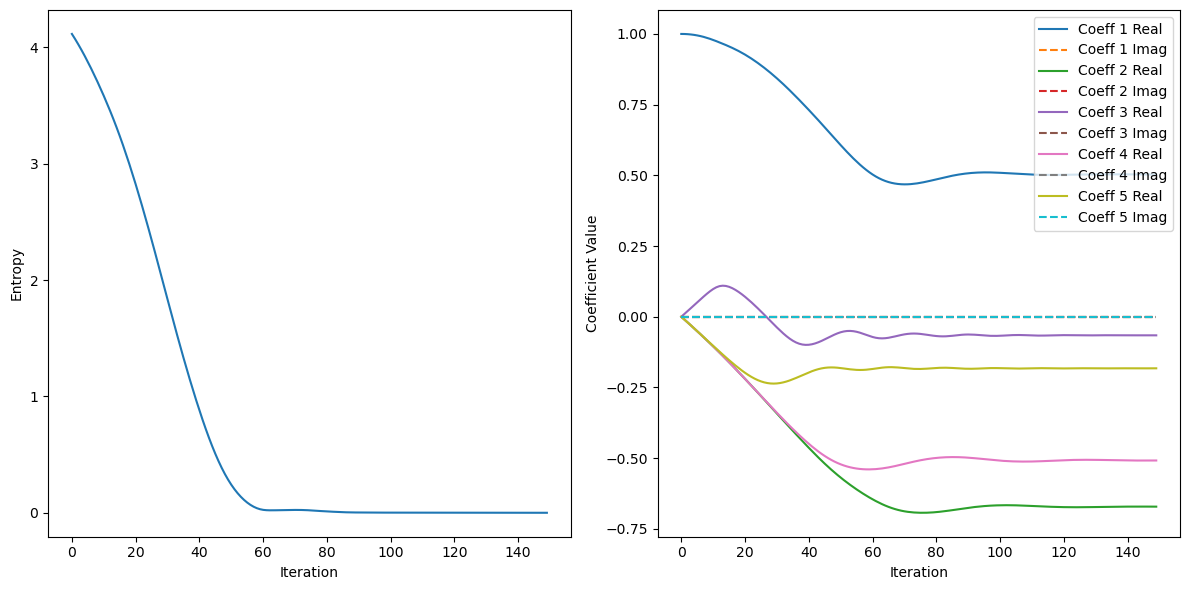

In [25]:
# find entropy min coeffs - everything  has to be in torch

# Initialize parameters for the coefficients with all values equal
#params_real = torch.full((5,), 1/np.sqrt(10), requires_grad=True)
#params_imag = torch.full((5,), 1/np.sqrt(10), requires_grad=True)

# Initialize parameters for the coefficients with random values
#params_real = torch.randn(5, requires_grad=True)
#params_imag = torch.randn(5, requires_grad=True)

# Convert random_coeffs to PyTorch tensors
#params_real = torch.tensor(random_coeffs.real, dtype=torch.float, requires_grad=True)
#params_imag = torch.tensor(random_coeffs.imag, dtype=torch.float, requires_grad=True)

params_real = torch.tensor(min_coeffs.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(min_coeffs.imag, dtype=torch.float, requires_grad=True)

# Compute the linear combination using the defined function
psi = linear_combination(torch.complex(params_real, params_imag), red_eigenvectors)

# if the outer products between scarred states are computed before optimization loop
# ....

# Compute entanglement entropy
entropy = entanglement_entropy_torch(psi, N // 2, N) 
print(f'Initial Entropy: {entropy.item()}')

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history_min = []
entropy_history = []

# Optimization loop
num_iterations = 150
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    # Compute psi
    psi = linear_combination(coeffs, red_eigenvectors)
    
    # Compute entanglement entropy
    entropy = entanglement_entropy_torch(psi, N // 2, N) # it would be better to compute the outer product of the state before the optimization loop. but optimization is not taking too long so it's ok for now
    
    # Backpropagation
    entropy.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {entropy.item()}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history_min.append(coeffs.detach().cpu().numpy())
    entropy_history.append(entropy.item())

# Final optimized coefficients
optimized_coeffs = torch.complex(params_real, params_imag)
optimized_coeffs = optimized_coeffs / torch.norm(optimized_coeffs)

print("Optimized coefficients:", optimized_coeffs)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(entropy_history)
plt.xlabel('Iteration')
plt.ylabel('Entropy')
#plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history_min = np.array(coeffs_history_min)
for i in range(coeffs_history_min.shape[1]):
    plt.plot(coeffs_history_min[:, i].real, label=f'Coeff {i+1} Real')
    plt.plot(coeffs_history_min[:, i].imag, label=f'Coeff {i+1} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
#plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# Compute torch bipartite ptrace before optimization

outer_products = []
partial_traces = []

red_eigenvectors = list(red_eigenvectors)
print(len(red_eigenvectors))

for i in tqdm(range(len(red_eigenvectors))):
    for j in tqdm(range(len(red_eigenvectors))):
        outer_product = np.outer(red_eigenvectors[i], red_eigenvectors[j].conj())
        outer_products.append(outer_product)

# Convert the list of outer products to a PyTorch tensor
outer_products = torch.tensor(outer_products, dtype=torch.float64)

print(len(outer_products))

# Compute the partial trace for each element in outer_products
for op in tqdm(outer_products):
    density_matrix_torch = torch.tensor(op, dtype=torch.float64)
    ptrace_op = ptrace_torch(op, list(range(N // 2)), [[2]*N, [2]*N])  # tracing out half system because I'm interested in bipartite entanglement entropy
    p_trace_op = torch.tensor(ptrace_op, dtype=torch.float64) #  necessary here?
    partial_traces.append(ptrace_op)

# Print the partial traces
for idx, pt in enumerate(partial_traces):
    print(f"Partial trace of outer product {idx}:\n{pt}\n")

5


100%|██████████| 5/5 [00:16<00:00,  3.32s/it]
C:\Users\camipolv\AppData\Local\Temp\ipykernel_9648\3672071811.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  outer_products = torch.tensor(outer_products, dtype=torch.float64)


25


  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\camipolv\AppData\Local\Temp\ipykernel_9648\3672071811.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  density_matrix_torch = torch.tensor(op, dtype=torch.float64)
C:\Users\camipolv\AppData\Local\Temp\ipykernel_9648\3672071811.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p_trace_op = torch.tensor(ptrace_op, dtype=torch.float64) #  necessary here?
100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


Partial trace of outer product 0:
tensor([[ 1.8359e-26,  1.6079e-18,  2.1850e-18,  ...,  2.2684e-18,
          3.2351e-18, -1.9458e-28],
        [ 1.6079e-18,  1.1645e-02, -3.2986e-15,  ..., -1.0612e-15,
          1.2423e-15, -1.7405e-18],
        [ 2.1850e-18, -3.2986e-15,  6.9926e-03,  ...,  4.8298e-16,
          2.3226e-16,  2.3133e-18],
        ...,
        [ 2.2684e-18, -1.0612e-15,  4.8298e-16,  ...,  6.9926e-03,
         -5.8923e-15, -4.3902e-17],
        [ 3.2351e-18,  1.2423e-15,  2.3226e-16,  ..., -5.8923e-15,
          1.1645e-02,  9.3786e-17],
        [-1.9458e-28, -1.7405e-18,  2.3133e-18,  ..., -4.3902e-17,
          9.3786e-17,  4.6539e-26]], dtype=torch.float64)

Partial trace of outer product 1:
tensor([[ 1.4528e-26, -2.9059e-17,  1.0546e-18,  ...,  7.7823e-19,
          2.9406e-19,  1.4392e-28],
        [-2.6453e-18,  1.5166e-03, -5.2601e-15,  ...,  6.7688e-16,
         -4.0285e-16,  3.3088e-18],
        [-1.1129e-17,  5.6352e-15,  1.1555e-03,  ...,  1.0944e-15,
     

In [27]:
'''# find entropy min coeffs - the traced out outer products of each scar is computed before optimization, in torch

# Initialize parameters for the coefficients with all values equal
#params_real = torch.full((5,), 1/np.sqrt(10), requires_grad=True
#params_imag = torch.full((5,), 1/np.sqrt(10), requires_grad=True)

# Initialize parameters for the coefficients with random values
#params_real = torch.randn(5, requires_grad=True)
#params_imag = torch.randn(5, requires_grad=True)

# Convert random_coeffs to PyTorch tensors
#params_real = torch.tensor(random_coeffs.real, dtype=torch.float, requires_grad=True)
#params_imag = torch.tensor(random_coeffs.imag, dtype=torch.float, requires_grad=True)

params_real = torch.tensor(min_coeffs.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(min_coeffs.imag, dtype=torch.float, requires_grad=True)


rho = linear_combination_outer(torch.complex(params_real, params_imag), outer_products)

# Compute entanglement entropy
entropy = entanglement_entropy_torch_ptrace(rho) 
print(f'Initial Entropy: {entropy.item()}')

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history_min = []
entropy_history = []

# Optimization loop
num_iterations = 150
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    rho = linear_combination_outer(coeffs, outer_products)
    
    # Compute entanglement entropy
    entropy = entanglement_entropy_torch_ptrace(rho) 
    
    # Backpropagation
    entropy.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {entropy.item()}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history_min.append(coeffs.detach().cpu().numpy())
    entropy_history.append(entropy.item())

# Final optimized coefficients
optimized_coeffs = torch.complex(params_real, params_imag)
optimized_coeffs = optimized_coeffs / torch.norm(optimized_coeffs)

print("Optimized coefficients:", optimized_coeffs)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(entropy_history)
plt.xlabel('Iteration')
plt.ylabel('Entropy')
#plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history_min = np.array(coeffs_history_min)
for i in range(coeffs_history_min.shape[1]):
    plt.plot(coeffs_history_min[:, i].real, label=f'Coeff {i+1} Real')
    plt.plot(coeffs_history_min[:, i].imag, label=f'Coeff {i+1} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
#plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()'''

'# find entropy min coeffs - the traced out outer products of each scar is computed before optimization, in torch\n\n# Initialize parameters for the coefficients with all values equal\n#params_real = torch.full((5,), 1/np.sqrt(10), requires_grad=True\n#params_imag = torch.full((5,), 1/np.sqrt(10), requires_grad=True)\n\n# Initialize parameters for the coefficients with random values\n#params_real = torch.randn(5, requires_grad=True)\n#params_imag = torch.randn(5, requires_grad=True)\n\n# Convert random_coeffs to PyTorch tensors\n#params_real = torch.tensor(random_coeffs.real, dtype=torch.float, requires_grad=True)\n#params_imag = torch.tensor(random_coeffs.imag, dtype=torch.float, requires_grad=True)\n\nparams_real = torch.tensor(min_coeffs.real, dtype=torch.float, requires_grad=True)\nparams_imag = torch.tensor(min_coeffs.imag, dtype=torch.float, requires_grad=True)\n\n\nrho = linear_combination_outer(torch.complex(params_real, params_imag), outer_products)\n\n# Compute entanglement e

Entropies of red points:
Index: 2825, Entropy: 4.115514364937272
Index: 2826, Entropy: 3.3614849366527304
Index: 2827, Entropy: 4.632998329262636
Index: 2828, Entropy: 4.118581173002276
Index: 2829, Entropy: 4.218787520105936
Min scar entropy: 1.3691684646547419e-05


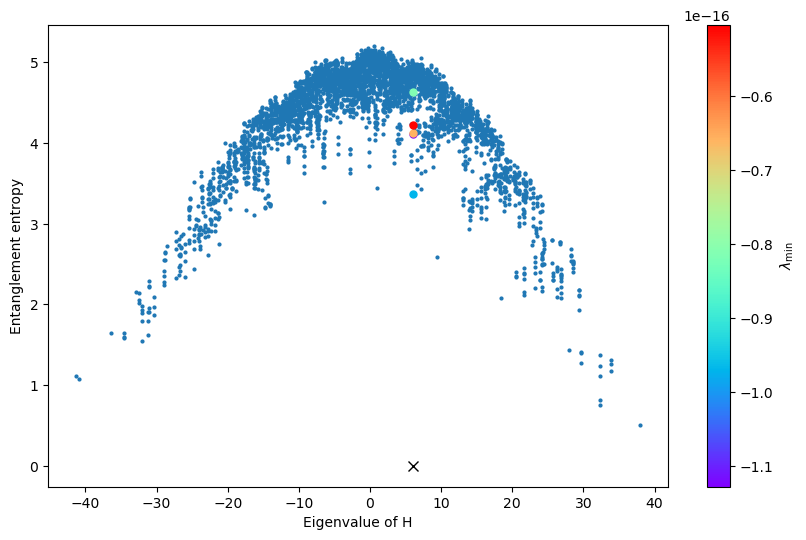

In [28]:
# Compute the max_scar wavefunction using the optimized coefficients (min entropy)
min_scar = linear_combination_np(coeffs_history_min[-1], red_eigenvectors)
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices)))

# Compute entanglement entropy for the max_scar wavefunction
min_scar_entropy = entanglement_entropy(min_scar, N // 2, N)

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {naive_entropies[i]}')

print(f'Min scar entropy: {min_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], naive_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices):
    handle, = ax.plot(eigenvalues[idx], naive_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(r'$\lambda_\mathrm{min}$: {float(min_eigenvalues[idx]):.2e}, Entropy: {naive_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
min_scar_handle, = ax.plot(np.mean(eigenvalues[red_indices]), min_scar_entropy, 'x', color='black', markersize=7)
handles.append(min_scar_handle)
labels.append('Min Scar, Entropy: {:.2f}'.format(min_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues[idx] for idx in red_indices]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label=r'$\lambda_{\mathrm{min}}$')

ax.set_xlabel('Eigenvalue of H')
ax.set_ylabel('Entanglement entropy')
plt.show()

Initial coeffs, real tensor([1., 0., 0., 0., 0.], requires_grad=True)
Initial coeffs imag tensor([0., 0., 0., 0., 0.], requires_grad=True)
Initial Entropy: 4.115515232086182
Coeffs norm: 0.99999994
Entropy: 4.115515232086182
Coeffs: [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Coeffs norm: 1.0
Entropy: 4.157244682312012
Coeffs: [ 0.9998001+0.j  0.009998 +0.j -0.009998 +0.j  0.009998 +0.j
  0.009998 +0.j]
Coeffs norm: 1.0
Entropy: 4.197576999664307
Coeffs: [ 0.9991898 +0.j  0.02012143+0.j -0.02012101+0.j  0.0201151 +0.j
  0.02013553+0.j]
Coeffs norm: 1.0
Entropy: 4.236151695251465
Coeffs: [ 0.99816144+0.j  0.03030368+0.j -0.03028705+0.j  0.03027868+0.j
  0.03035568+0.j]
Coeffs norm: 1.0
Entropy: 4.272802829742432
Coeffs: [ 0.99671084+0.j  0.04052557+0.j -0.04044433+0.j  0.04046191+0.j
  0.04064909+0.j]
Coeffs norm: 1.0
Entropy: 4.307406902313232
Coeffs: [ 0.9948391 +0.j  0.05076856+0.j -0.05051757+0.j  0.0506368 +0.j
  0.05100731+0.j]
Coeffs norm: 1.0
Entropy: 4.339839458465576
Coeffs: [ 0.9925

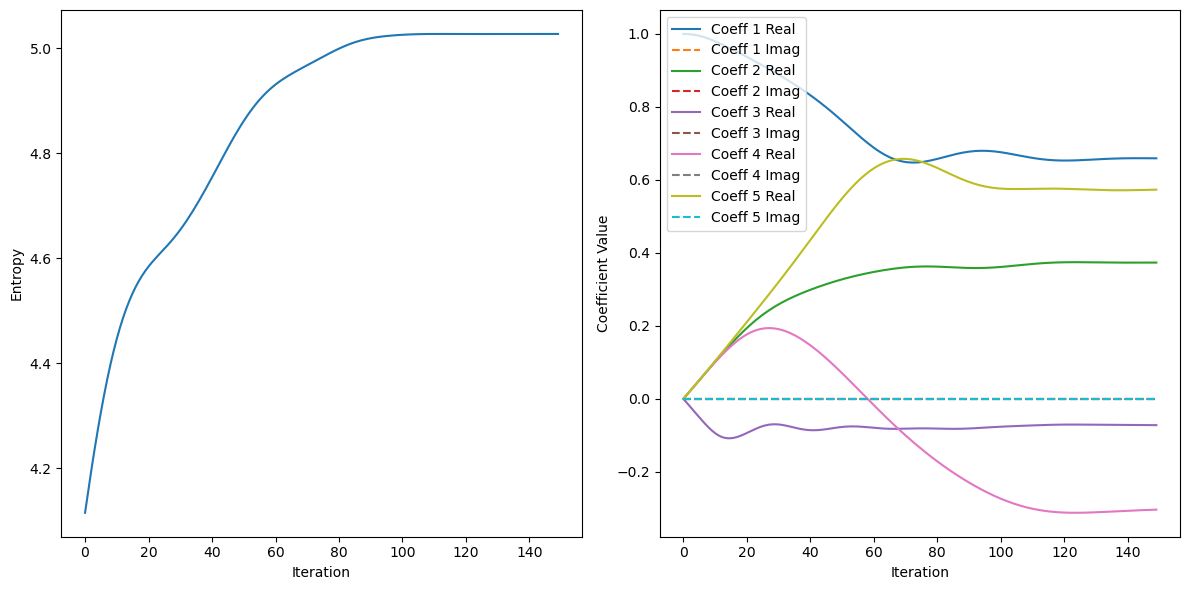

In [29]:
# now find entropy max coeffs - everything  has to be in torch

# Initialize parameters for the coefficients with all values equal
#params_real = torch.full((5,), 1/np.sqrt(10), requires_grad=True)
#params_imag = torch.full((5,), 1/np.sqrt(10), requires_grad=True)

# Initialize parameters for the coefficients with random values
#params_real = torch.randn(5, requires_grad=True)
#params_imag = torch.randn(5, requires_grad=True)

# Convert random_coeffs to PyTorch tensors
#params_real = torch.tensor(random_coeffs.real, dtype=torch.float, requires_grad=True)
#params_imag = torch.tensor(random_coeffs.imag, dtype=torch.float, requires_grad=True)

params_real = torch.tensor(max_coeffs.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(max_coeffs.imag, dtype=torch.float, requires_grad=True)

print("Initial coeffs, real", params_real)
print("Initial coeffs imag",  params_imag)

# Compute psi
psi = linear_combination(torch.complex(params_real, params_imag), red_eigenvectors)

# Compute entanglement entropy
entropy = entanglement_entropy_torch(psi, N // 2, N) 
print(f'Initial Entropy: {entropy.item()}')

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history_max = []
entropy_history_max = []

# Optimization loop
num_iterations = 150
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    # Compute psi
    psi = linear_combination(coeffs, red_eigenvectors)
    
    # Compute - entanglement entropy
    entropy = - entanglement_entropy_torch(psi, N // 2, N) # it would be better to compute the outer product of the state before the optimization loop. but optimization is not taking too long so it's ok for now
    
    # Backpropagation
    entropy.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {abs(entropy.item())}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history_max.append(coeffs.detach().cpu().numpy())
    entropy_history_max.append(abs(entropy.item()))

# Final optimized coefficients
optimized_coeffs_max = torch.complex(params_real, params_imag)
optimized_coeffs_max = optimized_coeffs_max / torch.norm(optimized_coeffs_max)

print("Optimized coefficients:", optimized_coeffs_max)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(np.abs(entropy_history_max))
plt.xlabel('Iteration')
plt.ylabel('Entropy')
#plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history_max = np.array(coeffs_history_max)
for i in range(coeffs_history_max.shape[1]):
    plt.plot(coeffs_history_max[:, i].real, label=f'Coeff {i+1} Real')
    plt.plot(coeffs_history_max[:, i].imag, label=f'Coeff {i+1} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
#plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()

Entropies of red points:
Index: 2825, Entropy: 4.115514364937272
Index: 2826, Entropy: 3.3614849366527304
Index: 2827, Entropy: 4.632998329262636
Index: 2828, Entropy: 4.118581173002276
Index: 2829, Entropy: 4.218787520105936
Max scar entropy: 5.027326314072227


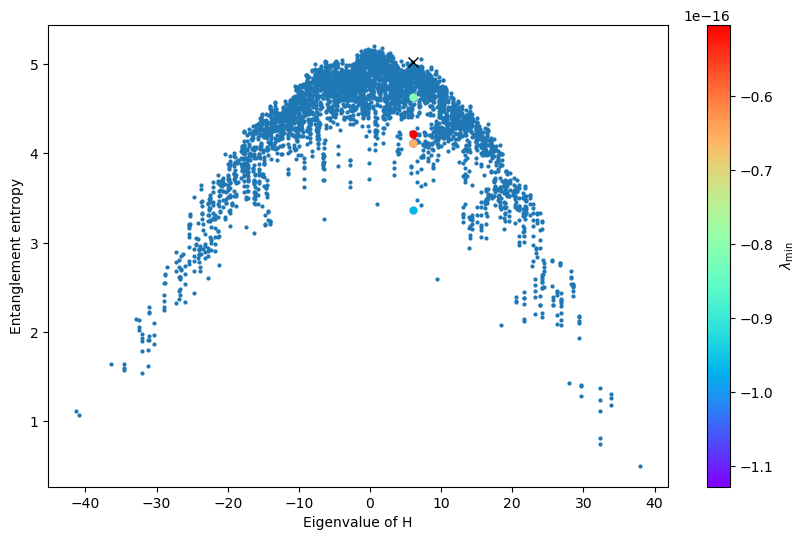

In [30]:
# Compute the max_scar wavefunction using the optimized coefficients (min entropy)
max_scar = linear_combination_np(coeffs_history_max[-1], red_eigenvectors)
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices)))

# Compute entanglement entropy for the max_scar wavefunction
max_scar_entropy = entanglement_entropy(max_scar, N // 2, N)

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {naive_entropies[i]}')

print(f'Max scar entropy: {max_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], naive_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices):
    handle, = ax.plot(eigenvalues[idx], naive_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(r'$\lambda_\mathrm{min}$: {float(min_eigenvalues[idx]):.2e}, Entropy: {naive_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
max_scar_handle, = ax.plot(np.mean(eigenvalues[red_indices]), max_scar_entropy, 'x', color='black', markersize=7)
handles.append(max_scar_handle)
labels.append('Max Scar, Entropy: {:.2f}'.format(max_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues[idx] for idx in red_indices]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label=r'$\lambda_{\mathrm{min}}$')

ax.set_xlabel('Eigenvalue of H')
ax.set_ylabel('Entanglement entropy')
#ax.set_title('Entanglement entropy as a function of energy eigenvalues')
#ax.legend(sorted_handles, sorted_labels)
plt.show()

In [31]:
# Look at properties of all of the 5 scars wavefunctions

for i in red_indices:

    print(f'Index: {i}, Energy: {eigenvalues[i]}, Entropy: {naive_entropies[i]}')

    #Count the number of zero entries
    num_zeros = np.count_nonzero((eigenvectors[i].real < 1e-16) & (eigenvectors[i].imag < 1e-16))
    print(f'Number of zero entries: {num_zeros}')

    rho_scar = np.dot(eigenvectors[i], eigenvectors[i].conj().T)
    print("Rank of rho scar i:", np.linalg.matrix_rank(rho_scar))

for i in (i for i in range(N) if i not in red_indices):
    #print(f'Index: {i}, Energy: {eigenvalues[i]}, Entropy: {naive_entropies[i]}')

    #Count the number of zero entries
    num_zeros = np.count_nonzero((eigenvectors[i].real < 1e-16) & (eigenvectors[i].imag < 1e-16))
    print(f'Number of zero entries: {num_zeros}')

Index: 2825, Energy: 5.999999999999997, Entropy: 4.115514364937272
Number of zero entries: 2366
Rank of rho scar i: 1
Index: 2826, Energy: 5.999999999999998, Entropy: 3.3614849366527304
Number of zero entries: 2390
Rank of rho scar i: 1
Index: 2827, Energy: 6.0, Entropy: 4.632998329262636
Number of zero entries: 2326
Rank of rho scar i: 1
Index: 2828, Energy: 6.000000000000001, Entropy: 4.118581173002276
Number of zero entries: 2379
Rank of rho scar i: 1
Index: 2829, Energy: 6.000000000000001, Entropy: 4.218787520105936
Number of zero entries: 2367
Rank of rho scar i: 1
Number of zero entries: 3999
Number of zero entries: 3303
Number of zero entries: 3295
Number of zero entries: 2735
Number of zero entries: 3280
Number of zero entries: 2757
Number of zero entries: 3368
Number of zero entries: 2523
Number of zero entries: 3290
Number of zero entries: 3375
Number of zero entries: 2779
Number of zero entries: 2556


In [32]:
# Look at structure of the wavefunction with these optimal coeffs corresp to min entropy

print(len(min_scar))

#Count the number of zero entries
num_zeros = np.count_nonzero((min_scar.real < 1e-16) & (min_scar.imag < 1e-16))
print(f'Number of zero entries: {num_zeros}')


rho_scar = np.dot(min_scar, min_scar.conj().T)
print("Rank of rho scar:", np.linalg.matrix_rank(rho_scar))

# Reshape psi into a 2^subsystem_size x 2^environment_size matrix
psi_matrix = min_scar.reshape((2**(N // 2), 2**(N // 2)))

# Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
rho_A = np.dot(psi_matrix, psi_matrix.conj().T)  # Partial trace over B

print(np.trace(rho_A))
print(np.trace(rho_A @ rho_A))
print(np.trace(np.dot(rho_A, rho_A)))

# Check if rho_A is Hermitian
is_hermitian = np.allclose(rho_A, rho_A.conj().T)
print(f'Is rho_A Hermitian? {is_hermitian}')

4096
Number of zero entries: 2396
Rank of rho scar: 1
(0.9999999510166131+0j)
(0.9999988756437562+0j)
(0.9999988756437562+0j)
Is rho_A Hermitian? True


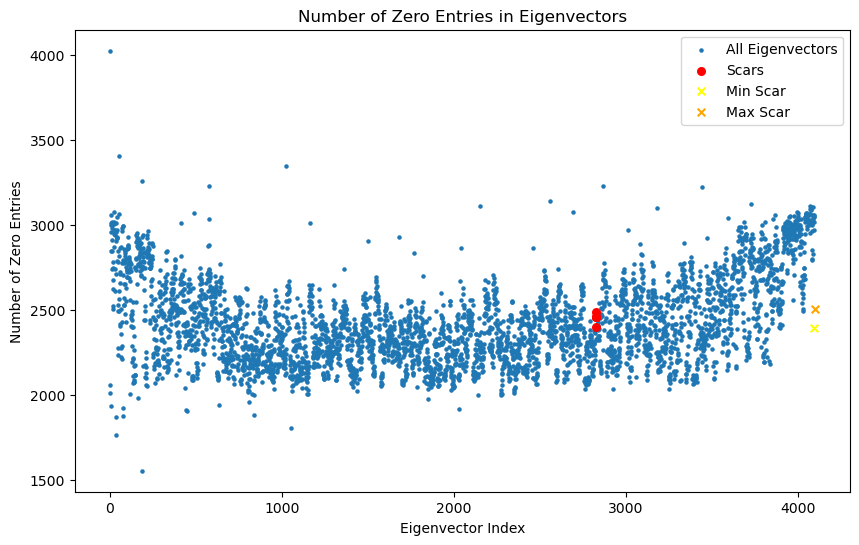

In [33]:
# Count the number of zero entries for all eigenvectors
num_zeros_all = [np.count_nonzero((eigenvectors[:, i].real < 1e-16) & (eigenvectors[:, i].imag < 1e-16)) for i in range(eigenvectors.shape[1])]

# Count the number of zero entries for red_eigenvectors
num_zeros_red = [np.count_nonzero((red_eigenvectors[i].real < 1e-16) & (red_eigenvectors[i].imag < 1e-16)) for i in range(len(red_eigenvectors))]

# Count the number of zero entries for min_scar and max_scar
num_zeros_min_scar = np.count_nonzero((min_scar.real < 1e-16) & (min_scar.imag < 1e-16))
num_zeros_max_scar = np.count_nonzero((max_scar.real < 1e-16) & (max_scar.imag < 1e-16))

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot all eigenvectors in color 'C0'
plt.scatter(range(len(num_zeros_all)), num_zeros_all, color='C0', label='All Eigenvectors', s=5)

# Highlight red_eigenvectors in red
for i, idx in enumerate(red_indices):
    plt.scatter(idx, num_zeros_red[i], color='red', label='Scars' if i == 0 else "", s=30)

# Mark min_scar and max_scar with yellow and orange crosses - and put them at the end of the plot
plt.scatter(len(num_zeros_all), num_zeros_min_scar, color='yellow', marker='x', s=30, label='Min Scar')
plt.scatter(len(num_zeros_all) + 1, num_zeros_max_scar, color='orange', marker='x', s=30, label='Max Scar')

# Add labels and legend
plt.xlabel('Eigenvector Index')
plt.ylabel('Number of Zero Entries')
plt.legend()
plt.title('Number of Zero Entries in Eigenvectors')
plt.show()

In [34]:
# List to store the number of dependent columns and their indices for each matrix
dependent_columns_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Perform QR decomposition with column pivoting
    Q, R, pivot_indices = qr(rdm, pivoting=True)
    
    # Determine rank using a threshold on the diagonal of R
    tol = 1e-12
    rank = np.sum(np.abs(np.diag(R)) > tol)
    
    # Calculate the number of dependent columns
    num_dependent_columns = 16 - rank
    
    # Identify dependent columns
    dependent_columns = sorted(set(range(16)) - set(pivot_indices[:rank]))
    dependent_columns_info.append((num_dependent_columns, dependent_columns))
    
    print(f"Number of dependent columns: {num_dependent_columns}")
    print(f"Dependent columns indices: {dependent_columns}")
    print("-" * 50)

# Print the results
print("Dependent columns info for each matrix:", dependent_columns_info)

RDM Index: 0
Number of dependent columns: 5
Dependent columns indices: [0, 4, 12, 14, 15]
--------------------------------------------------
RDM Index: 1
Number of dependent columns: 5
Dependent columns indices: [0, 2, 9, 13, 15]
--------------------------------------------------
RDM Index: 2
Number of dependent columns: 5
Dependent columns indices: [0, 1, 3, 11, 15]
--------------------------------------------------
RDM Index: 3
Number of dependent columns: 5
Dependent columns indices: [0, 2, 6, 7, 15]
--------------------------------------------------
RDM Index: 4
Number of dependent columns: 5
Dependent columns indices: [0, 1, 3, 14, 15]
--------------------------------------------------
Dependent columns info for each matrix: [(5, [0, 4, 12, 14, 15]), (5, [0, 2, 9, 13, 15]), (5, [0, 1, 3, 11, 15]), (5, [0, 2, 6, 7, 15]), (5, [0, 1, 3, 14, 15])]


In [35]:
# List to store the null space information for each matrix
null_spaces_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Compute the null space of the RDM
    null_space_rdm = null_space(rdm)
    
    # Store the null space information
    null_spaces_info.append(null_space_rdm)
    
    # Print the null space dimensions and basis vectors
    print(f"Null space dimension: {null_space_rdm.shape[1]}")
    print(f"Null space basis vectors:\n{null_space_rdm}")
    print("-" * 50)

# Print the results
print("Null space information for each matrix computed.")

RDM Index: 0
Null space dimension: 5
Null space basis vectors:
[[-4.72669035e-09  1.19807351e-09 -2.70406612e-09  1.65497775e-02
   9.99863043e-01]
 [-2.34347774e-01  4.40413258e-01  3.34257877e-02 -4.13555358e-11
  -1.54448094e-09]
 [-2.34347774e-01  4.40413258e-01  3.34257877e-02 -4.13548803e-11
  -1.54447838e-09]
 [-3.49767703e-01 -1.77522786e-01 -1.13202832e-01  6.99688891e-10
  -1.75848855e-09]
 [-2.34347774e-01  4.40413258e-01  3.34257877e-02 -4.13545193e-11
  -1.54447542e-09]
 [-3.49767703e-01 -1.77522786e-01 -1.13202832e-01  6.99661148e-10
  -1.75846644e-09]
 [-3.49767703e-01 -1.77522786e-01 -1.13202832e-01  6.99610740e-10
  -1.75848879e-09]
 [ 1.07586952e-01  9.36197249e-02 -4.79228959e-01  1.63356843e-09
  -9.26661980e-10]
 [-2.34347774e-01  4.40413258e-01  3.34257877e-02 -4.13550335e-11
  -1.54447883e-09]
 [-3.49767703e-01 -1.77522786e-01 -1.13202832e-01  6.99723881e-10
  -1.75846411e-09]
 [-3.49767703e-01 -1.77522786e-01 -1.13202832e-01  6.99701772e-10
  -1.75847489e-09]
 [

In [36]:
# List to store the number of dependent columns and their indices for each matrix
dependent_columns_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Perform QR decomposition with column pivoting
    Q, R, pivot_indices = qr(rdm, pivoting=True)
    
    # Determine rank using a threshold on the diagonal of R
    tol = 1e-12
    rank = np.sum(np.abs(np.diag(R)) > tol)
    
    # Calculate the number of dependent columns
    num_dependent_columns = 16 - rank
    
    # Identify dependent columns
    dependent_columns_indices = sorted(set(range(16)) - set(pivot_indices[:rank]))
    dependent_columns_info.append((num_dependent_columns, dependent_columns_indices))
    
    # Print the number of dependent columns and their indices
    print(f"Number of dependent columns: {num_dependent_columns}")
    print(f"Dependent columns indices: {dependent_columns_indices}")
    
    # Print the actual dependent columns
    dependent_columns = rdm[:, dependent_columns_indices]
    print(f"Dependent columns:\n{dependent_columns}")
    print("-" * 50)

# Print the results
print("Dependent columns info for each matrix:", dependent_columns_info)

RDM Index: 0
Number of dependent columns: 5
Dependent columns indices: [0, 4, 12, 14, 15]
Dependent columns:
[[ 5.49374897e-26 -5.61860978e-17  4.26733853e-15 -1.12686933e-17
  -3.57109764e-27]
 [ 7.35435418e-17  3.84823210e-03  1.81686282e-17  1.19974605e-15
  -1.92379751e-17]
 [-4.26507330e-17 -3.24960277e-02  1.83384953e-16 -3.43231406e-15
   2.53585222e-17]
 [ 2.17268595e-15  1.89206631e-16 -1.74738378e-03 -3.31820295e-16
  -1.62173417e-15]
 [-5.61860978e-17  2.31496486e-02 -3.30399055e-17  4.94817186e-15
   4.06332940e-18]
 [-1.42650904e-15  1.94537140e-17  4.60418629e-03  1.51026245e-16
   1.47448056e-15]
 [-1.91750926e-15  9.71407276e-18 -6.25174175e-02 -1.75899810e-17
  -2.69594352e-15]
 [-6.72909685e-18 -8.53174517e-15 -2.27163941e-16  6.54158091e-03
  -4.49368200e-18]
 [ 2.52932890e-17  5.49814691e-03  8.56799623e-17 -1.64163226e-16
  -1.01838765e-17]
 [-1.54026629e-15  9.76815727e-18  7.53301050e-03  2.29133743e-16
   2.40435249e-15]
 [-1.55573989e-15  8.39879880e-17 -3.4433

In [37]:
#find a 4/5 spins charge commuting with the rdm - let's first use quantum channel to derive the effective action of the global C5 symmetry operator on the 4 spins subsystem:

##   rho4' = Tr_8[C5 (rho4 cross rho8) C5^dagger], and compare it to rho4
##   C5^4 = Tr_8[C5 (I4 cross rho8)] --- not sure if this is correct, but let's try it anyway

# let's first find rho8 - we already have rho4 and C5=P

In [38]:
# Compute RDM on the complement of keep_qubits for scarred eigenstates
complement_rdms = []  # List to store RDMs on the complement of keep_qubits

# Define the complement of keep_qubits
all_qubits = set(range(N))
for i in red_indices:
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Complement of keep_qubits
    complement_qubits = list(all_qubits - set(keep_qubits))

    # Trace out the complement qubits
    traced_out_complement = ptrace(density_matrix_qobj, complement_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_complement_dense = traced_out_complement.full()
    complement_rdms.append(traced_out_complement_dense)

    # Compute the trace of the complement RDM
    trace_value = np.trace(traced_out_complement_dense)

    # Check if the complement RDM is Hermitian
    is_hermitian = np.allclose(traced_out_complement_dense, traced_out_complement_dense.conj().T)

    # Print the results for debugging
    print(f"Complement RDM for eigenstate {i}:")
    print(f"Shape: {traced_out_complement_dense.shape}")
    print(f"Trace: {trace_value}")
    print(f"Is Hermitian: {is_hermitian}")
    print("-" * 50)

# Now `complement_rdms` contains the RDMs on the complement of keep_qubits for all scarred eigenstates

Complement RDM for eigenstate 2825:
Shape: (256, 256)
Trace: (0.9999999999999996+0j)
Is Hermitian: True
--------------------------------------------------
Complement RDM for eigenstate 2826:
Shape: (256, 256)
Trace: (0.9999999999999997+0j)
Is Hermitian: True
--------------------------------------------------
Complement RDM for eigenstate 2827:
Shape: (256, 256)
Trace: (1.0000000000000004+0j)
Is Hermitian: True
--------------------------------------------------
Complement RDM for eigenstate 2828:
Shape: (256, 256)
Trace: (0.9999999999999994+0j)
Is Hermitian: True
--------------------------------------------------
Complement RDM for eigenstate 2829:
Shape: (256, 256)
Trace: (0.9999999999999989+0j)
Is Hermitian: True
--------------------------------------------------


In [39]:
# full P=C5

P = dok_matrix((2**N, 2**N), dtype=np.float64)

# Go through all basis states
for index in range(2**N):
    # Convert index to spin bits
    state_bits = list(map(int, np.binary_repr(index, width=N)))
    
    # Apply the permutation
    new_bits = apply_permutation(state_bits, N, perm)
    
    # Convert back to integer index
    new_index = int("".join(map(str, new_bits)), 2)
    
    # Set the permutation matrix entry
    P[new_index, index] = 1.0

# Optionally convert to CSR format for efficient multiplication
P = P.toarray()

print("Permutation matrix P constructed with shape:", P.shape)

Permutation matrix P constructed with shape: (4096, 4096)


In [40]:
# first attempt for the effective 4-spins operator C5^4

C5_4s = []

P_qobj = Qobj(P, dims=[[2]*N, [2]*N])


for i in range(len(complement_rdms)):
    rho8 = complement_rdms[i]
    # Convert rho8 (NumPy matrix) back to Qobj
    rho8_qobj = Qobj(rho8, dims=[[2] * (N - len(keep_qubits)), [2] * (N - len(keep_qubits))])

    # Define subsystem dimensions
    dim_A = 2**(len(keep_qubits))   # e.g., 4 spins → dimension 16
    dim_B = rho8_qobj.dims[0][0]  # This should be 2**(N-4) for N spins total

    # Identity on subsystem A
    IA_qobj = qeye(dim_A)
    IA = np.eye(dim_A, dtype=np.float64)  # Identity matrix for subsystem A

    # Build the product state (I_A ⊗ rhoB)
    #IA_rho8 = tensor(IA, rho8_qobj)
    IA_rho8 = np.kron(IA, rho8)  # Kronecker product of I_A and rhoB
    IA_rho8_qobj = Qobj(IA_rho8, dims=[[2] * N, [2] * N])

    # Print dimensions
    print(f"Dimension of IA: {IA.shape}")
    print(f"Dimension of rho8_qobj: {rho8.shape}")
    print(f"Dimension of IA_rho8: {IA_rho8_qobj.dims}")

    # Apply global C5 (P) to this state
    U_rho = P_qobj * IA_rho8_qobj

    # Partial trace over subsystem B → result acts on subsystem A
    # If A is the first subsystem in the tensor product, trace out B (which is subsystem 1)
    #C5_4 = ptrace(U_rho, 0)  # 0 → subsystem A (remaining after tracing out B)
    C5_4 = ptrace(U_rho, keep_qubits)  # Trace out the complement of keep_qubits

    # Now C5_tilde is the effective operator acting on subsystem A (4 spins)
    C5_4s.append(C5_4.full())  # Convert to dense matrix if needed
    print(f"Effective operator C5^4 for eigenstate {i}:")
    print(f"Shape: {C5_4.shape}")

Dimension of IA: (16, 16)
Dimension of rho8_qobj: (256, 256)
Dimension of IA_rho8: [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]
Effective operator C5^4 for eigenstate 0:
Shape: (16, 16)
Dimension of IA: (16, 16)
Dimension of rho8_qobj: (256, 256)
Dimension of IA_rho8: [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]
Effective operator C5^4 for eigenstate 1:
Shape: (16, 16)
Dimension of IA: (16, 16)
Dimension of rho8_qobj: (256, 256)
Dimension of IA_rho8: [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]
Effective operator C5^4 for eigenstate 2:
Shape: (16, 16)
Dimension of IA: (16, 16)
Dimension of rho8_qobj: (256, 256)
Dimension of IA_rho8: [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]
Effective operator C5^4 for eigenstate 3:
Shape: (16, 16)
Dimension of IA: (16, 16)
Dimension of rho8_qobj: (256, 256)
Dimension of IA_rho8: [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2,

In [41]:
for i in range(len(C5_4s)):
    print(f"Effective operator C5^4 for eigenstate {i}:")
    print(f"Shape: {C5_4s[i].shape}")
    print(C5_4s[i])
    print("-" * 50)

Effective operator C5^4 for eigenstate 0:
Shape: (16, 16)
[[-6.17171302e-03+0.j -6.93813889e-18+0.j  1.88772271e-18+0.j
  -9.12400978e-15+0.j -2.09797057e-16+0.j  2.12936745e-15+0.j
   6.99794653e-15+0.j  4.79747987e-17+0.j -1.50681055e-16+0.j
  -1.15990271e-15+0.j  1.71189920e-15+0.j  3.45811315e-17+0.j
  -5.52653322e-16+0.j  2.37074384e-17+0.j  1.40856987e-17+0.j
  -9.27058768e-16+0.j]
 [-1.10629293e-16+0.j -3.95452137e-03+0.j -3.84823210e-03+0.j
  -1.78762689e-16+0.j -8.18456122e-04+0.j  6.76522411e-18+0.j
   1.01751247e-16+0.j -2.79104893e-15+0.j  2.44949658e-03+0.j
   1.33410520e-17+0.j -6.23224391e-17+0.j -1.19456002e-14+0.j
   4.34725840e-18+0.j  3.33136481e-15+0.j -5.32826280e-16+0.j
  -4.82854217e-17+0.j]
 [-1.67729580e-16+0.j -5.25043631e-04+0.j  8.46434800e-04+0.j
  -7.75161132e-17+0.j -2.55520863e-03+0.j -1.41857200e-17+0.j
  -7.82728208e-18+0.j -1.78484774e-15+0.j -3.93789555e-03+0.j
  -1.06304508e-16+0.j  2.95266852e-17+0.j  4.03547193e-15+0.j
  -2.03517557e-16+0.j -4.951

In [42]:
# Compute commutators between each C5_4 and the corresponding rho4
commutators = []

for i in range(len(C5_4s)):
    # Convert rho4 (min_rdms) to a dense matrix if needed
    rho4 = min_rdms[i]  # Corresponding reduced density matrix (rho4)
    C5_4 = C5_4s[i]     # Corresponding effective operator (C5_4)

    # Compute the commutator: [C5_4, rho4] = C5_4 * rho4 - rho4 * C5_4
    commutator = np.dot(C5_4, rho4) - np.dot(rho4, C5_4)
    commutators.append(commutator)

    # Print the commutator for debugging
    print(f"Commutator for scar {i}:")
    print(commutator)
    print(f"Norm of commutator: {np.linalg.norm(commutator)}")
    print("-" * 50)

# Now `commutators` contains the commutators for all eigenstates

Commutator for scar 0:
[[-9.20857148e-31+0.j -2.69877910e-18+0.j  1.83490799e-17+0.j
  -8.50725812e-16+0.j -4.71380585e-18+0.j  7.83249753e-16+0.j
   5.44553693e-17+0.j  1.52324723e-18+0.j -1.09364950e-17+0.j
  -1.39646991e-16+0.j  8.14089739e-16+0.j  2.79798386e-19+0.j
  -6.61422058e-16+0.j -1.76779140e-18+0.j -3.52542179e-20+0.j
  -1.10942980e-28+0.j]
 [-3.17446676e-18+0.j  1.48814929e-04+0.j -3.21046834e-04+0.j
  -1.55214680e-17+0.j  6.37294762e-05+0.j  6.96304958e-18+0.j
  -1.50855221e-18+0.j -6.80778802e-16+0.j  1.08502428e-04+0.j
   7.23293703e-18+0.j  3.16377658e-18+0.j  2.87651992e-16+0.j
  -1.33364360e-17+0.j  9.03901380e-16+0.j -8.24817905e-18+0.j
   1.28844755e-18+0.j]
 [ 1.95467151e-17+0.j -1.01357623e-04+0.j -1.44870857e-04+0.j
  -6.99747875e-18+0.j -2.55835981e-04+0.j  1.70180234e-17+0.j
   9.18000369e-18+0.j  7.56983476e-16+0.j  5.02064462e-04+0.j
  -3.75740406e-18+0.j  2.61698804e-17+0.j -6.92573116e-16+0.j
   3.30689254e-18+0.j -4.06794188e-16+0.j -2.16145800e-16+0.j
 

In [43]:
# second attempt for the effective 4-spins operator C5^4 - check that rho4' matrix norm is the same or close to rho4 matrix norm

C5_4s = []

P_qobj = Qobj(P, dims=[[2]*N, [2]*N])


for i in range(len(complement_rdms)):
    rho8 = complement_rdms[i]
    # Convert rho8 (NumPy matrix) back to Qobj
    rho8_qobj = Qobj(rho8, dims=[[2] * (N - len(keep_qubits)), [2] * (N - len(keep_qubits))])

    # Define subsystem dimensions
    dim_A = 2**(len(keep_qubits))   # e.g., 4 spins → dimension 16
    dim_B = rho8_qobj.dims[0][0]  # This should be 2**(N-4) for N spins total

    # Identity on subsystem A
    IA_qobj = qeye(dim_A)
    IA = np.eye(dim_A, dtype=np.float64)  # Identity matrix for subsystem A

    # Build the product state (I_A ⊗ rhoB)
    #IA_rho8 = tensor(IA, rho8_qobj)
    IA_rho8 = np.kron(IA, rho8)  # Kronecker product of I_A and rhoB
    IA_rho8_qobj = Qobj(IA_rho8, dims=[[2] * N, [2] * N])

    # Print dimensions
    print(f"Dimension of IA: {IA.shape}")
    print(f"Dimension of rho8_qobj: {rho8.shape}")
    print(f"Dimension of IA_rho8: {IA_rho8_qobj.dims}")

    # Apply global C5 (P) to this state
    U_rho = P_qobj * IA_rho8_qobj

    # Partial trace over subsystem B → result acts on subsystem A
    # If A is the first subsystem in the tensor product, trace out B (which is subsystem 1)
    #C5_4 = ptrace(U_rho, 0)  # 0 → subsystem A (remaining after tracing out B)
    C5_4 = ptrace(U_rho, keep_qubits)  # Trace out the complement of keep_qubits

    # Now C5_tilde is the effective operator acting on subsystem A (4 spins)
    C5_4s.append(C5_4.full())  # Convert to dense matrix if needed
    print(f"Effective operator C5^4 for eigenstate {i}:")
    print(f"Shape: {C5_4.shape}")

Dimension of IA: (16, 16)
Dimension of rho8_qobj: (256, 256)
Dimension of IA_rho8: [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]
Effective operator C5^4 for eigenstate 0:
Shape: (16, 16)
Dimension of IA: (16, 16)
Dimension of rho8_qobj: (256, 256)
Dimension of IA_rho8: [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]
Effective operator C5^4 for eigenstate 1:
Shape: (16, 16)
Dimension of IA: (16, 16)
Dimension of rho8_qobj: (256, 256)
Dimension of IA_rho8: [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]
Effective operator C5^4 for eigenstate 2:
Shape: (16, 16)
Dimension of IA: (16, 16)
Dimension of rho8_qobj: (256, 256)
Dimension of IA_rho8: [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]
Effective operator C5^4 for eigenstate 3:
Shape: (16, 16)
Dimension of IA: (16, 16)
Dimension of rho8_qobj: (256, 256)
Dimension of IA_rho8: [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [2, 2,